In [1]:
%matplotlib inline
import scipy.signal
import matplotlib
import matplotlib.pyplot as pl
import numpy as np
import itertools
from commpy.filters import rrcosfilter
import math
import random


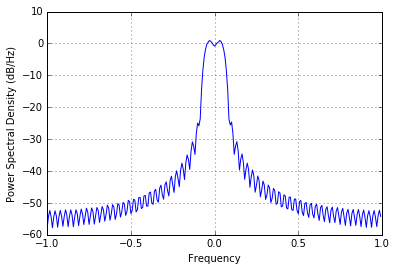

In [223]:
N_data = int(8192)
BR=33e9
analog_rate=16*BR
fix_adc_rate=5/3*BR
import random
N_data = int(10*1024)

def gen_data_rx(alfa=0.1):
    data = np.array([complex(2*random.randint(0,1)-1,2*random.randint(0,1)-1) for i in xrange(N_data)])
    data_zeros = np.zeros((N_data*16,1),dtype=complex).flatten()
    data_zeros[1::16] = data    
    rcos_filter = rrcosfilter(64,alfa,1/BR,16*BR)[1]
    power_of_filter = np.sqrt(np.sum([ np.square(j) for j in rcos_filter]))
    rcos_filter = rcos_filter/power_of_filter
    data_interp = np.convolve(rcos_filter, data_zeros,'same')
    return data_interp

def gen_noise(SNRdb=13):
    sigma_noise = 1/np.sqrt(10**(SNRdb/10.0))
    noise = np.array([complex(np.random.normal(scale=sigma_noise),np.random.normal(scale=sigma_noise)) for i in xrange(N_data*16)])
    return noise
    
Signal = gen_data_rx(0.17)
Noise=gen_noise()
pl.psd(Signal)
#pl.psd(Noise)
#pl.psd(np.add(Signal,Noise))
pl.show()


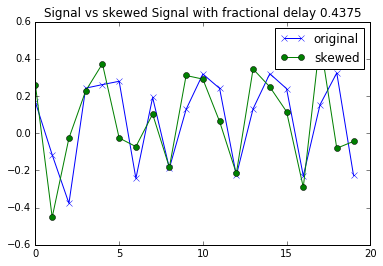

In [224]:
from fractions import Fraction
a=Fraction(fix_adc_rate/analog_rate)
N_proc=512
sk_in_samples=7
def sample_data():
    sampled_data=scipy.signal.resample(Signal[:N_proc*8],int(N_proc*8*a))
    skewed_data=scipy.signal.resample(Signal[sk_in_samples:N_proc*8+sk_in_samples],int(N_proc*8*a))
    return (sampled_data,skewed_data)

(sampled_data,skewed_data) = sample_data()
pl.plot(np.real(sampled_data[-20:]),'-x',label='original')
pl.plot(np.real(skewed_data[-20:]),'o-',label='skewed')
pl.title('Signal vs skewed Signal with fractional delay {0}'.format(sk_in_samples/16.0))
pl.legend()
pl.show()

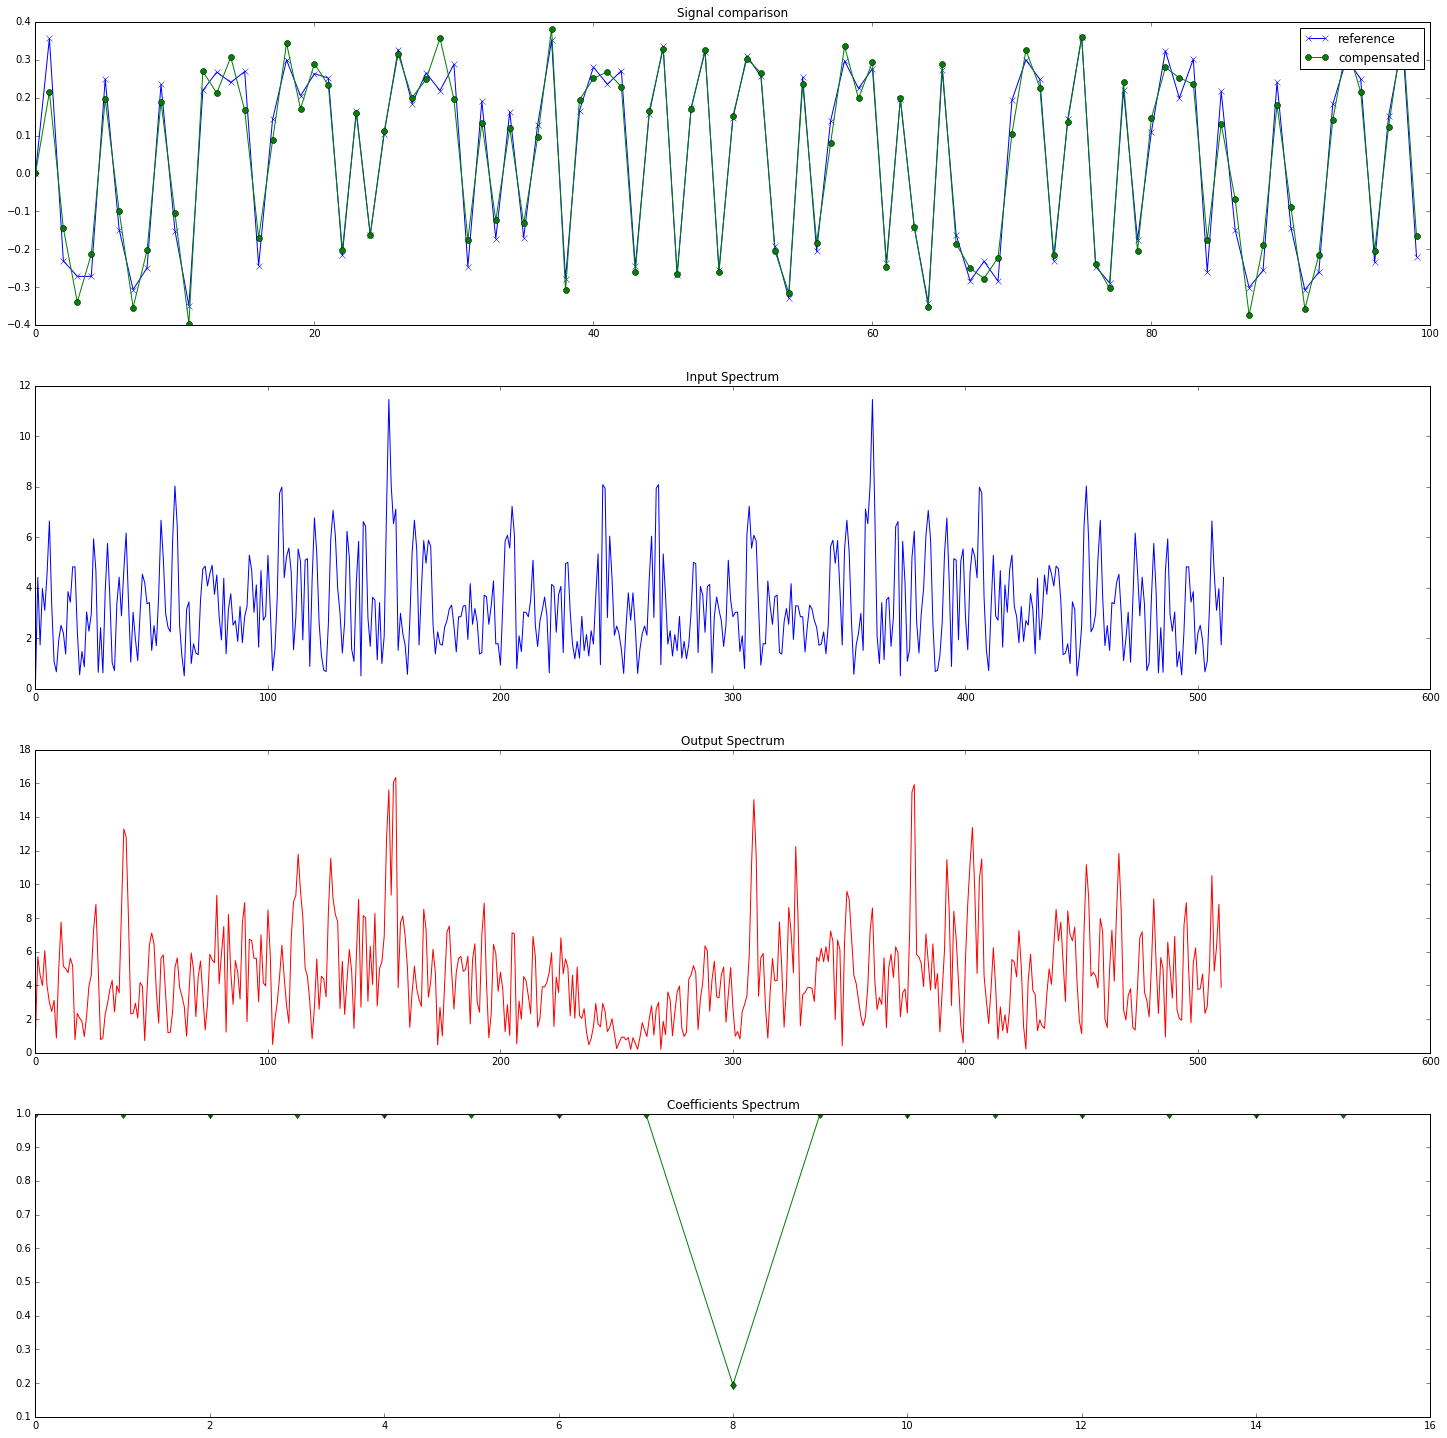

[ 1.00000000+0.j          0.98527764-0.17096189j  0.94154407-0.33688985j
  0.87008699-0.49289819j  0.77301045-0.63439328j  0.65317284-0.75720885j
  0.51410274-0.85772861j  0.35989504-0.9329928j   0.19509032+0.j
  0.35989504+0.9329928j   0.51410274+0.85772861j  0.65317284+0.75720885j
  0.77301045+0.63439328j  0.87008699+0.49289819j  0.94154407+0.33688985j
  0.98527764+0.17096189j]


In [225]:
fft_size=16#len(sampled_data)
def fd_compensation():
    D=1.0*sk_in_samples/16
    
    y=np.zeros((1,1))
    phases_pos = [np.exp(np.complex(0,-i*(D)*2*np.pi/fft_size)) for i in range(1,fft_size/2)]
    phases_neg = [np.exp(np.complex(0,(fft_size-i)*(D)*2*np.pi/fft_size)) for i in range(fft_size/2+1,fft_size)]
    phases_pos = np.append(1,phases_pos)
    phases_neg = np.append(np.real(np.exp(np.complex(0,-(D)*np.pi))),phases_neg)
    phases= np.append(phases_pos,phases_neg)
    for i in range(N_proc/fft_size):
        regress=fft_size-2
        x=skewed_data[i*(regress):(i*regress)+fft_size]
        f=np.fft.fft(x,fft_size)
        g=np.array([f[i]*phases[i] for i in range(fft_size)])
        y=np.append(y,np.fft.ifft(g,fft_size)[1:-1])
    return (x,y,f,g,phases)

(x,y,f,g,phases)=fd_compensation()
pl.figure(figsize=(25,25))
pl.title('FD Results')
pl.subplot(4,1,1)
pl.title('Signal comparison')
pl.plot(np.imag(sampled_data[:100]),'-x',label='reference')
pl.plot(np.imag(y[:100]),'-o',label='compensated')
pl.legend()
pl.subplot(4,1,2)
pl.title('Input Spectrum')
pl.plot(abs(np.fft.fft(np.real(skewed_data),512)))
pl.subplot(4,1,3)
pl.title('Output Spectrum')
pl.plot(abs(np.fft.fft(y,512))[:511],'r')
pl.subplot(4,1,4)
pl.title('Coefficients Spectrum')
pl.plot(np.abs((phases)),'g-d')

pl.show()
print phases

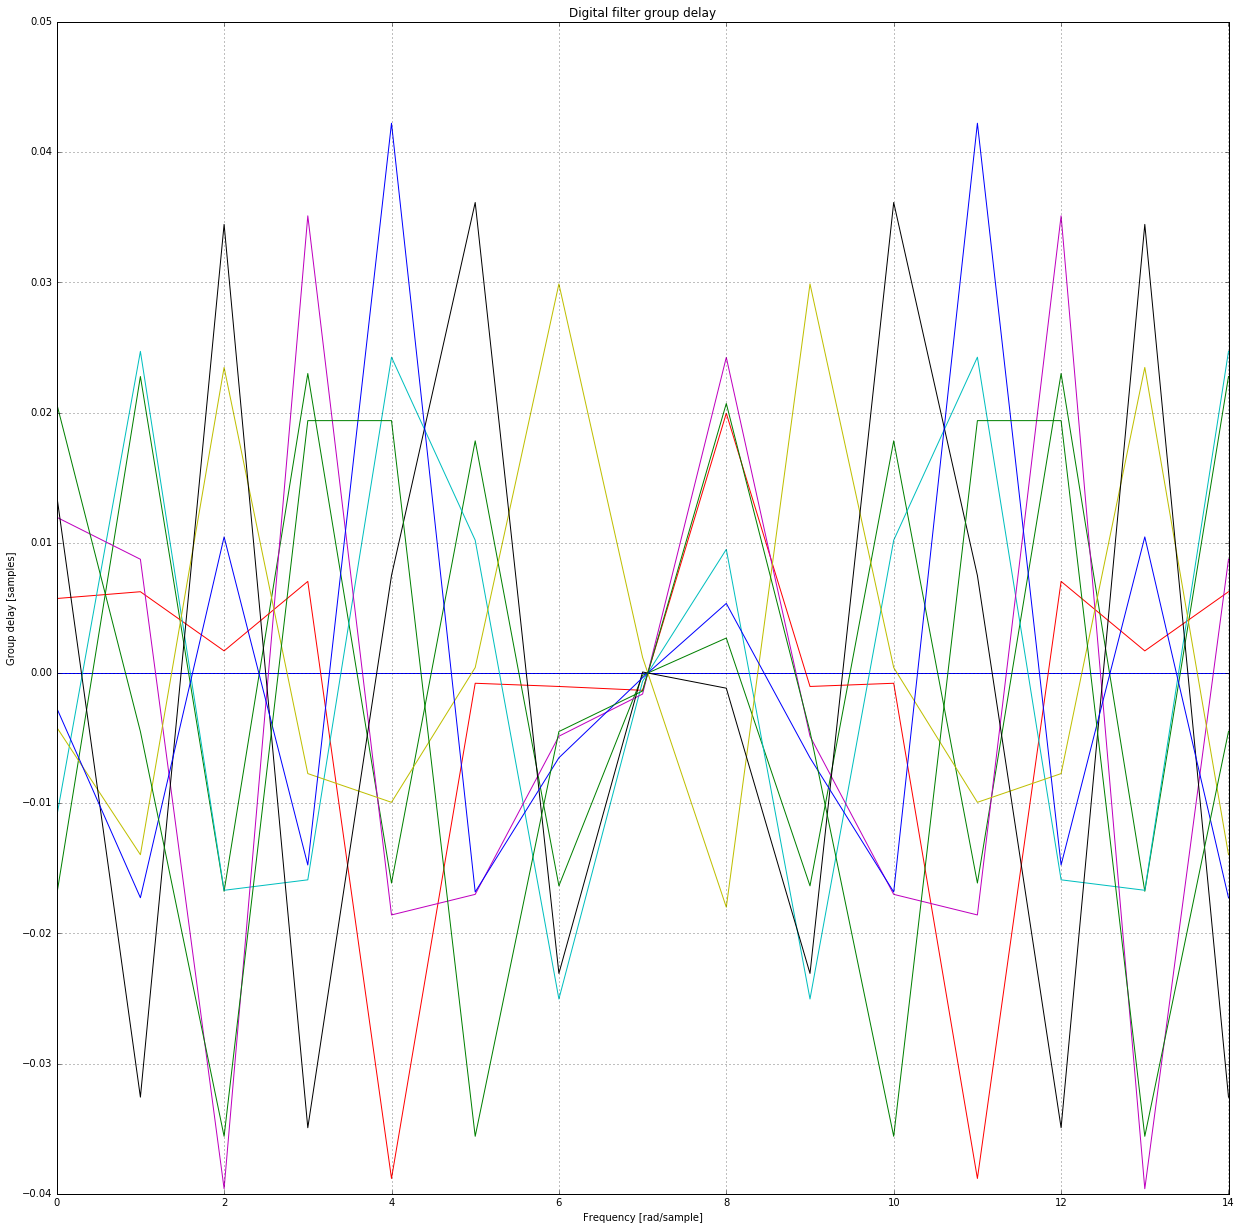

In [226]:
from deModel import DeFixedInt
pl.figure(figsize=[21,21])
pl.title('Coefficients Phase')
w=np.fft.fftfreq(fft_size, d=1.)
fd_taps_quantized=[np.complex(DeFixedInt(1,8,float(np.real(i))).fValue,DeFixedInt(1,6,float(np.imag(i))).fValue) for i in phases]
for m in range(9):
    sk_in_samples=m
    (x,y,f,g,phases)=fd_compensation()
    fd_taps_quantized=[np.complex(DeFixedInt(2,6,float(np.real(i))).fValue,DeFixedInt(2,6,float(np.imag(i))).fValue) for i in phases]
    pl.title('Digital filter group delay')
    g_d=-1*(np.diff(np.unwrap(np.pi*np.angle(phases))/np.pi) / np.diff(2*np.pi*w))
    g_d_q=-1*(np.diff(np.unwrap(np.pi*np.angle(fd_taps_quantized))/np.pi) / np.diff(2*np.pi*w))
    #pl.plot(np.diff(np.angle(phases))-np.diff(np.angle(fd_taps_quantized)))
    freqs=w[:-1]
    error=g_d-g_d_q
    pl.plot(error)
    
pl.ylabel('Group delay [samples]')
pl.xlabel('Frequency [rad/sample]')
pl.grid()
pl.legend()

pl.show()


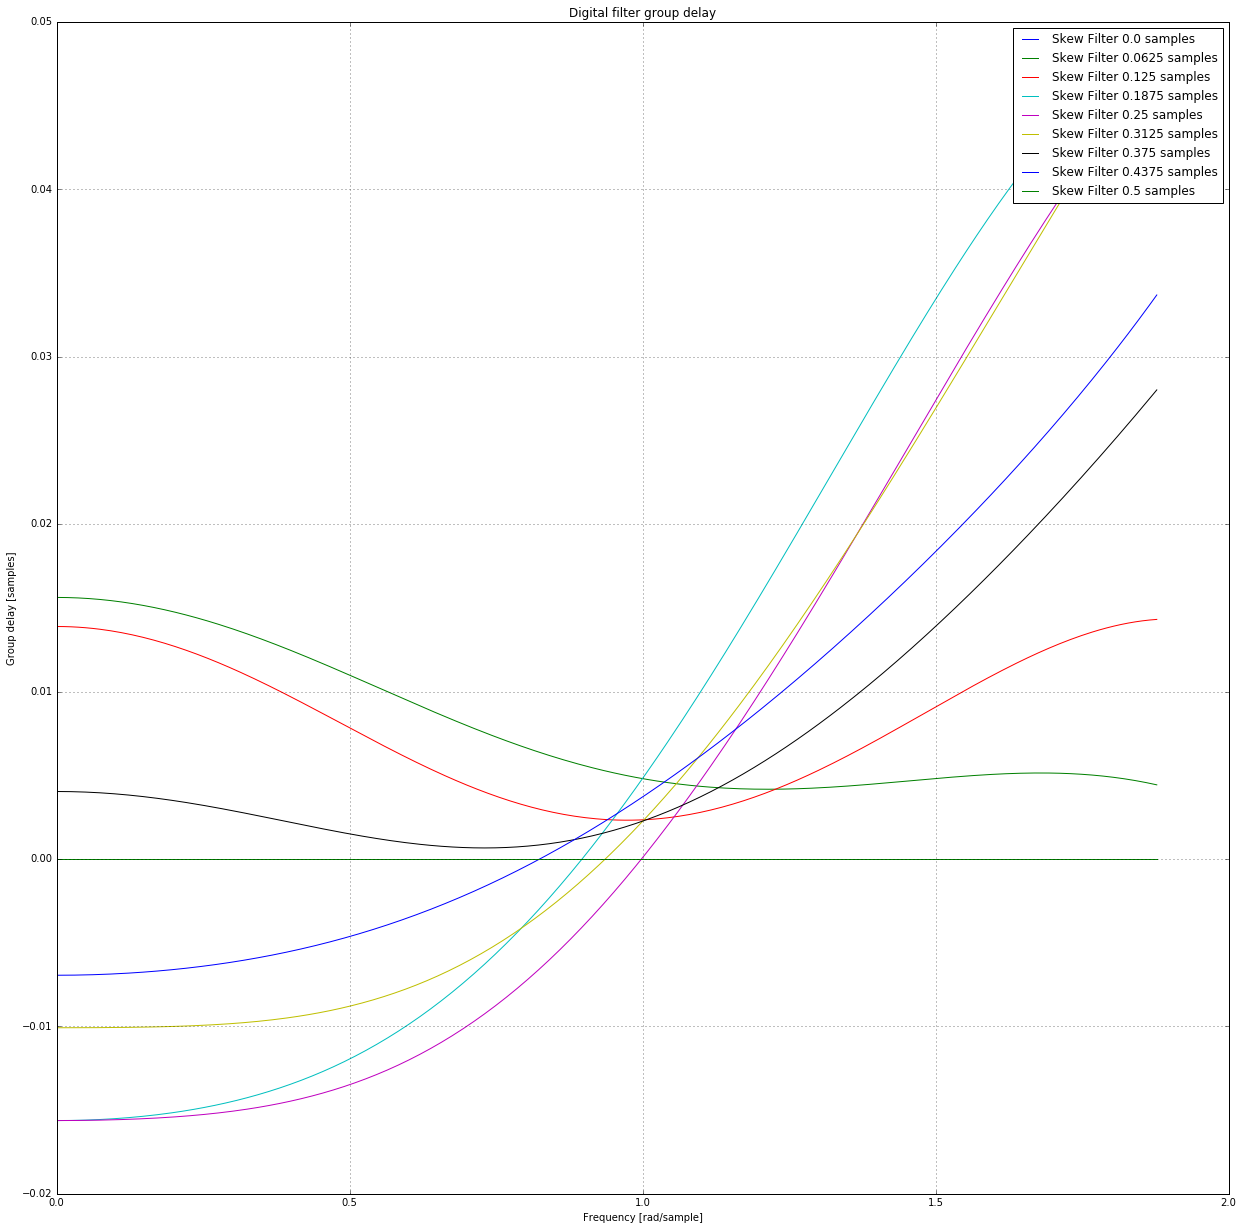

In [227]:
from deModel import DeFixedInt

def td_compensation():
    n_index=64
    n_taps=6                   
    d = sk_in_samples*4.0/n_index;
    D = d + math.ceil(n_taps/2)-1;
    x=skewed_data
    taps=[]
    for j in range(n_taps):     # // Taps Generation
        c_double = 1.0
        for k in range(n_taps): #// Products Generation
            if (k!=j):
              c_double = c_double * ((D-k)/(j-k))
        taps.append(c_double)
    taps.reverse()
    y = [  sum(taps*x[i:i+6]) for i in range(len(x)-6)]
    
    return y,taps
pl.figure(figsize=[21,21])
for m in range(9):
    sk_in_samples=m
    z,taps=td_compensation()
    taps_with_q_noise=[i+random.gauss(mu=0,sigma=2*np.sqrt(2.**(-12)/12)) for i in taps]
    taps_quantized=[DeFixedInt(2,6,i,roundMode='trunc').fValue for i in taps]
    w, gd = scipy.signal.group_delay((taps_quantized,[1]))
    w, gd_pure = scipy.signal.group_delay((taps,[1]))
    
    pl.title('Digital filter group delay')
    limit=len(w)*3/5
    pl.plot(w[:limit], gd[:limit]-gd_pure[:limit],label="Skew Filter "+str(sk_in_samples/16.)+" samples")
pl.ylabel('Group delay [samples]')
pl.xlabel('Frequency [rad/sample]')
pl.grid()
pl.legend()

pl.show()

In [ ]:
a = DeFixedInt

In [ ]:
a = DeFixedInt

In [214]:
*a.fValue

SyntaxError: invalid syntax (<ipython-input-214-f6cfdc71e9e3>, line 1)

/usr/local/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


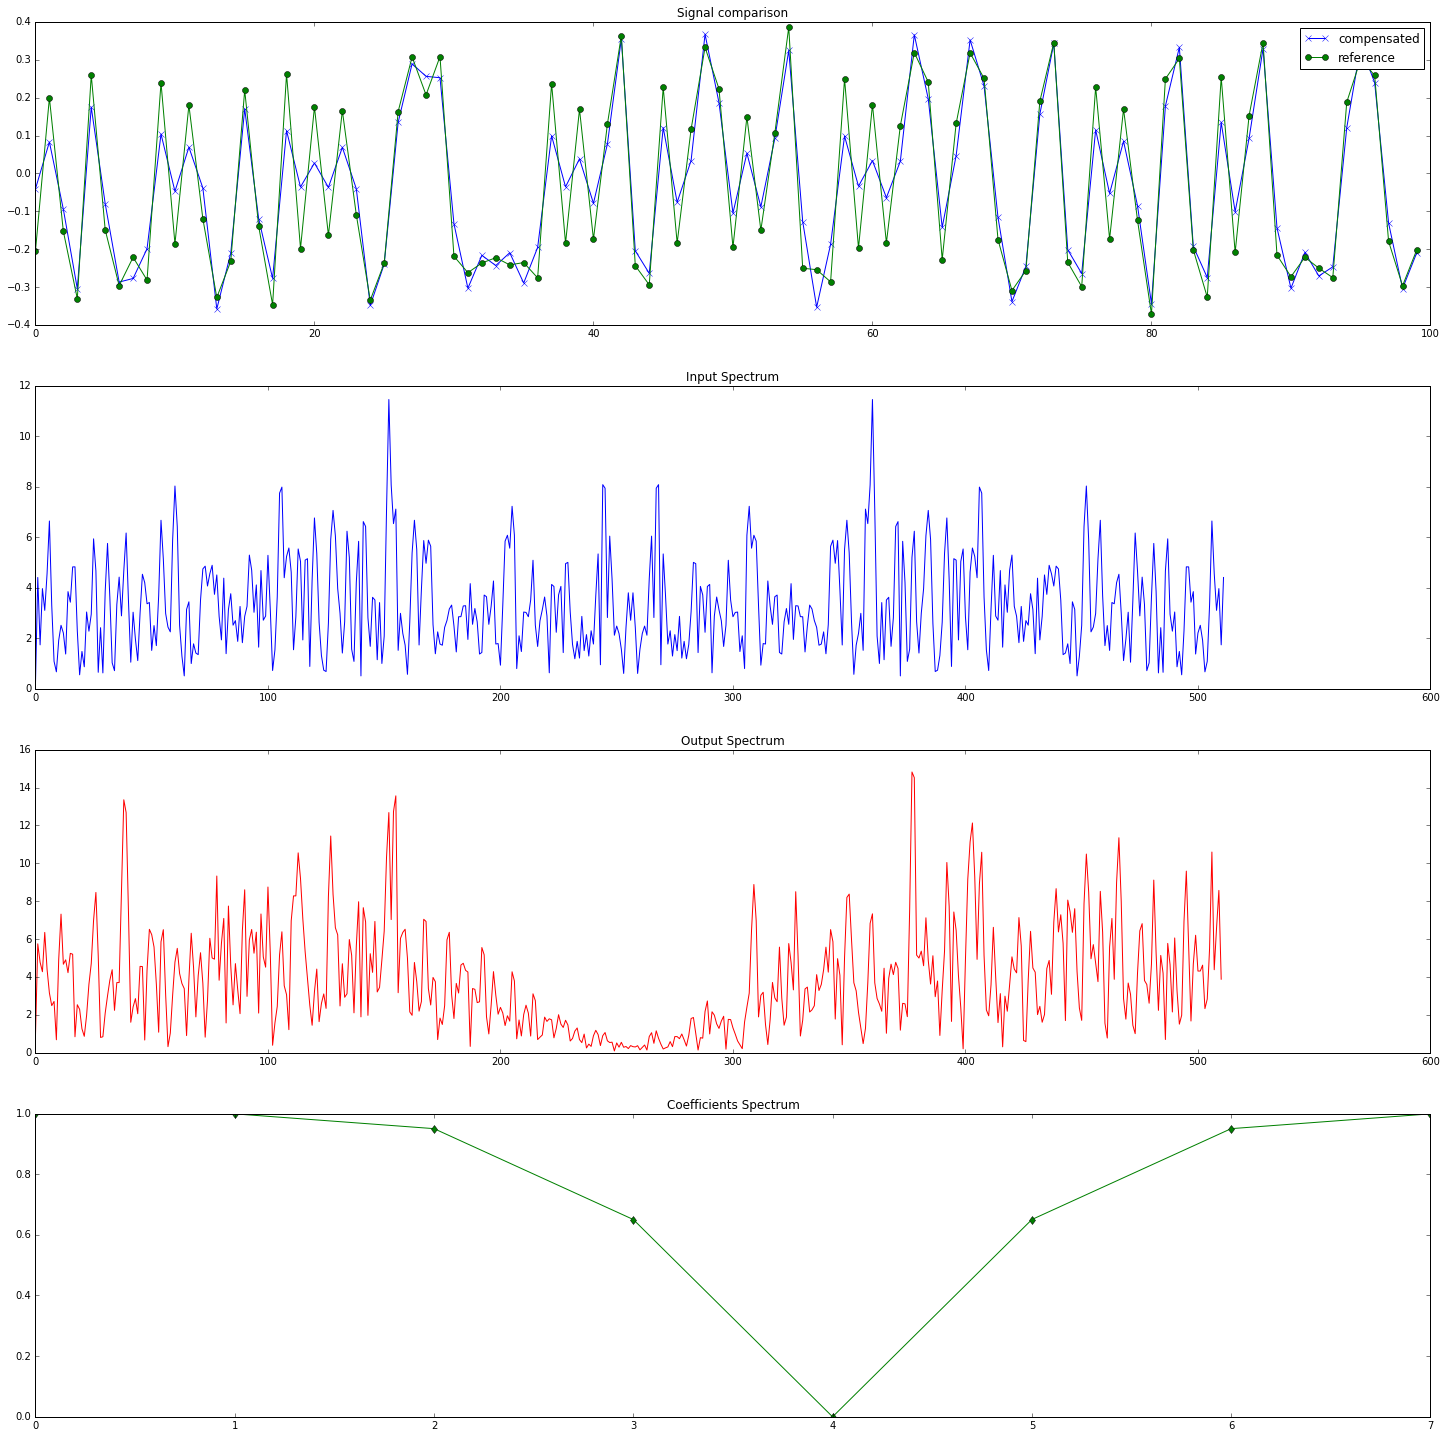

In [228]:
#pl.plot(y[1:],label='compensated')
#pl.plot(z[:100],'-x',label='compensated TD')
#pl.plot(skewed_data[3:],'-o',label='original with skew')
#pl.plot(sampled_data[3:103],'-d',label='original without skew')
pl.figure(figsize=(25,25))
pl.title('TD Results')
pl.subplot(4,1,1)
pl.title('Signal comparison')
pl.plot(z[:100],'-x',label='compensated')
pl.plot(sampled_data[3:103],'-o',label='reference')
pl.legend()
pl.subplot(4,1,2)
pl.title('Input Spectrum')
pl.plot(abs(np.fft.fft(np.real(skewed_data),512)))
pl.subplot(4,1,3)
pl.title('Output Spectrum')
pl.plot(abs(np.fft.fft(z,512))[:511],'r')
pl.subplot(4,1,4)
pl.title('Coefficients Spectrum')
pl.plot(np.abs(np.fft.fft(taps,8)),'g-d')

pl.legend()
pl.show()

Calculo de RMSD

In [8]:
def calc_fd_rmsd():
    rmsd = np.sqrt(sum([  np.abs(y[1+i]-sampled_data[1+i])**2 for i in range(len(sampled_data)-1)])/(len(sampled_data)-1))
    return rmsd
def calc_td_rmsd():
    rmsd = np.sqrt(sum([  np.abs(z[i]-sampled_data[3+i])**2 for i in range(len(z)-5)])/(len(z)-5))
    return rmsd

sk_in_samples=1
(sampled_data,skewed_data) = sample_data()
(x,y,f,g,phases)=fd_compensation()
z,taps=td_compensation()
print sk_in_samples,calc_td_rmsd(),calc_fd_rmsd()

sk_in_samples=13
(sampled_data,skewed_data) = sample_data()
(x,y,f,g,phases)=fd_compensation()
z,taps=td_compensation()
print sk_in_samples,calc_td_rmsd(),calc_fd_rmsd()

1 0.0203625959848 0.0172305814093
13 0.0564036851751 0.0557798605963


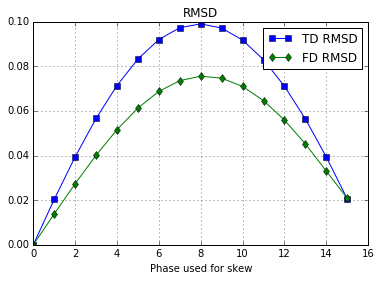

In [9]:
td_rmsd=[]
fd_rmsd=[]
fft_size=16
for i in range(16):
    sk_in_samples=i
    (sampled_data,skewed_data) = sample_data()
    (x,y,f,g,phases)=fd_compensation()
    z,taps=td_compensation()
    td_rmsd.append(calc_td_rmsd())
    fd_rmsd.append(calc_fd_rmsd())

pl.title('RMSD')
pl.plot(td_rmsd,'s-',label='TD RMSD')
pl.plot(fd_rmsd,'d-',label='FD RMSD')
pl.xlabel( 'Phase used for skew')
pl.grid()
pl.legend()
pl.show()

# Demostracion de que x(n)+j*y(n) = X(w)+Y(w)

In [10]:
x_real=np.random.random_sample(8)
y_real= np.random.random_sample(8)
X=np.fft.fft([np.complex(i,0) for i in x_real])
Y=np.fft.fft([np.complex(0,i) for i in y_real])
XY=np.fft.fft([np.complex(i,j) for i,j in zip(x_real,y_real)])
Z=X+Y
print Z-XY
print X



[  0.00000000e+00 +0.00000000e+00j   5.55111512e-17 +0.00000000e+00j
   0.00000000e+00 +0.00000000e+00j  -5.55111512e-17 -5.55111512e-17j
   0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +2.22044605e-16j
   0.00000000e+00 +0.00000000e+00j   0.00000000e+00 +0.00000000e+00j]
[ 2.87170177+0.j          0.86964717-0.05070284j -0.22389840-0.83338451j
 -0.05257544-0.3796181j   0.18887275+0.j         -0.05257544+0.3796181j
 -0.22389840+0.83338451j  0.86964717+0.05070284j]


# Calculo de recursos de filtro FD

In [236]:
parallelism=160
radix=8
n_ffts=math.ceil(parallelism/(radix-4.0))

#multiplicadores full del filtro (en 0 y N/2 es real, el resto son el producto y el producto de sus complejos
#se comparten productos parciales, se necesitan 4 multiplicadores full cada 2 taps, o sea 2 por tap )
multipliers=(2*(radix-2.0)+2)*n_ffts
adders=(2*(radix-2.0)+24*4)*n_ffts
reference_adders = 5*parallelism
reference_mults = 6*parallelism
print n_ffts,multipliers,reference_mults
print n_ffts,adders,reference_adders


40.0 560.0 960
40.0 4320.0 800
